# Tâche 8


Calculer la vitesse du son pour trois branches acoustiques différentes dans trois directions différentes de la zone de Brillouin.

In [1]:
import numpy as np
from mp_api.client import MPRester
from pymatgen.core.operations import SymmOp
from pymatgen.symmetry.analyzer import SpacegroupAnalyzer
from pymatgen.electronic_structure.plotter import BSPlotter
from pymatgen.phonon.plotter import PhononBSPlotter
from jupyter_jsmol.pymatgen import quick_view
from lmapr1492 import plot_brillouin_zone, get_plot_bs, get_plot_dos, get_plot_bs_and_dos, get_branch_wavevectors
from plotly.subplots import make_subplots
import plotly.graph_objects as go
import math
import matplotlib.pyplot as plt  

In [2]:
mp_key = "xaEW7gxeGjtHSTeJuWSz9Uf8JpzNlgtg"
mp_id = "mp-9382"

In [3]:
with MPRester(mp_key) as m:
    prim_struc = m.get_structure_by_material_id(mp_id)
    ph_bs = m.get_phonon_bandstructure_by_material_id(mp_id)

Retrieving MaterialsDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

Retrieving PhononBSDOSDoc documents:   0%|          | 0/1 [00:00<?, ?it/s]

# 1) Représentation des bandes de phonons

<Axes: xlabel='$\\mathrm{Wave\\ Vector}$', ylabel='$\\mathrm{Frequencies\\ (THz)}$'>

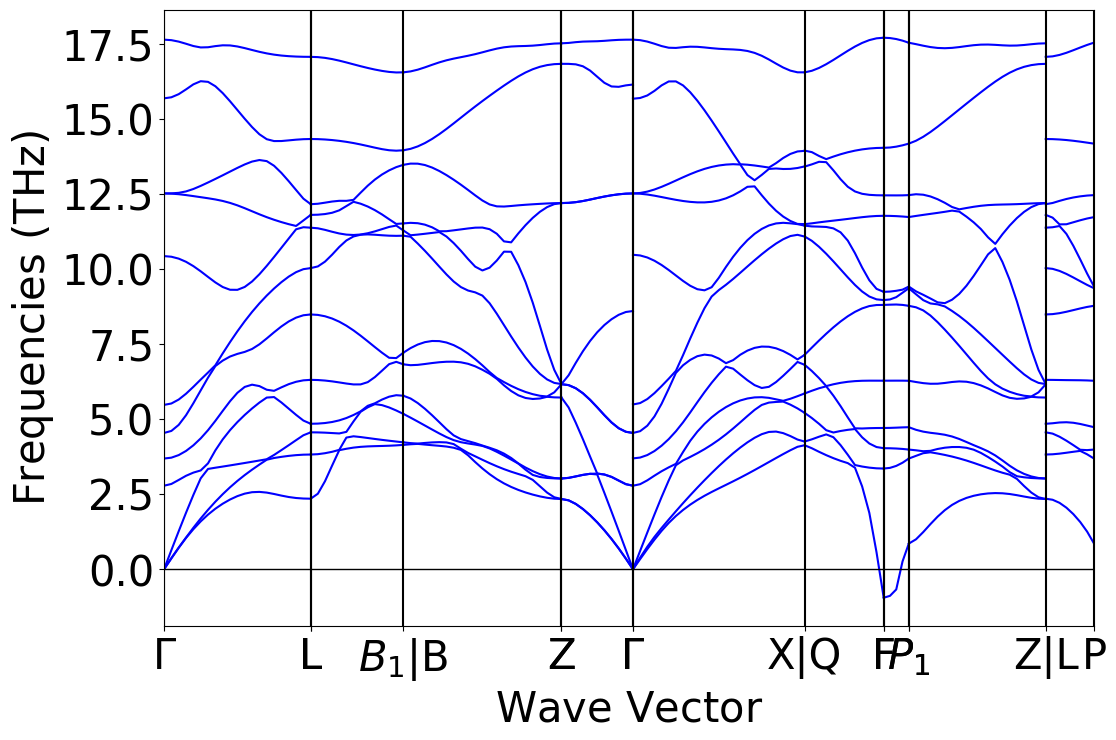

In [4]:
PhononBSPlotter(ph_bs).get_plot()

# 2) Représentation de la zone de Brillouin

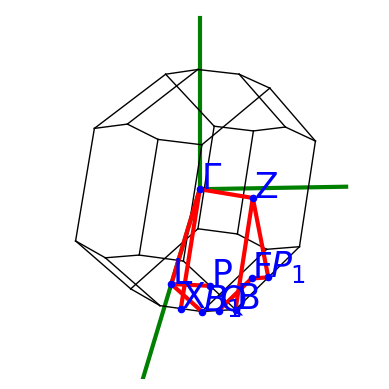

In [5]:
ph_plot = PhononBSPlotter(ph_bs)
plot_brillouin_zone(ph_bs.structure)
ph_plot.plot_brillouin()

# 3) Calcul des vitesses du son

Pour les phonons acoustiques, la vitesse du son correspond à la vitesse de groupe, c’est-à-dire la vitesse à laquelle se propage l’énergie vibratoire dans le solide. Elle se définit mathématiquement comme la dérivée de la fréquence angulaire $ \omega $ par rapport à la norme du vecteur d’onde $q$ : $v_{\text{son}} = \frac{d\omega}{dq}$.

Cette expression reflète la pente de la courbe de dispersion $ \omega(q)$, c’est-à-dire la variation de la fréquence des vibrations en fonction du vecteur d’onde. Plus cette pente est élevée, plus l’onde se propage rapidement dans le matériau.

Près de l’origine de la zone de Brillouin (pour $q \approx 0 $), les branches acoustiques présentent généralement un comportement linéaire, ce qui permet d’estimer les vitesses du son longitudinales et transverses à partir de la pente de ces courbes. Près de q=0 (c’est-à-dire pour les grandes longueurs d’onde), la vitesse de groupe des phonons acoustiques est constante et correspond à la vitesse du son dans le matériau.

Ce comportement linéaire constitue une hypothèse fondamentale du modèle de Debye, qui propose une description simplifiée des modes vibratoires dans un solide.  Dans ce modèle, la relation de dispersion des phonons acoustiques est supposée linéaire sur toute la zone de Brillouin, selon :$\omega(q) = v \cdot q$, où  $v$ est la vitesse du son. 

Enfin, pour convertir les fréquences classiques $f$ (en hertz) en pulsations $\omega$ (en rad/s), on utilise la relation : $ \omega = 2\pi f$


### Extraction des données

In [6]:
data = PhononBSPlotter(ph_bs).bs_plot_data()
distances = data['distances']
frequency = data['frequency']
directions = data['ticks']['label']

### Identification des branches accoustiques

Il est essentiel de bien identifier les branches acoustiques. Pour faire ceci, rappelons que ces branches correspondent à des modes de vibration dans lesquels tous les atomes de la maille oscillent globalement dans la même direction, comme dans une onde sonore classique

À l’origine de la zone de Brillouin (au point Γ) , leur fréquence est toujours nulle, en raison de l’invariance par translation du cristal. Cela signifie qu’un déplacement uniforme de tous les atomes ne génère aucune force de rappel, donc aucune vibration propre à cette échelle.

Dans les diagrammes de dispersion, cette propriété se traduit par une fréquence $\omega = 0$  lorsque le vecteur d’onde $q$ est nul. C’est cette caractéristique que l’on exploite pour identifier automatiquement les branches acoustiques parmi l’ensemble des modes calculés

In [7]:
def find_acoustic_branches(frequencies):
    frequence = []
    branche = []
    zone = []

    for i in range(len(frequencies)):  # boucle sur les segments (ex: Γ-X, K-Γ, ...)
        for j in range(len(frequencies[i])):  # boucle sur les branches de chaque segment
            
            # Condition : la fréquence est nulle au début ou à la fin, ou déja enregistrée comme branche accoustique
            if (frequencies[i][j][0] == 0 or frequencies[i][j][-1] == 0) and j not in branche and i not in zone:
                zone.append(i)
                branche.append(j)
                frequence.append(frequencies[i][j])

            if len(branche) == 3:  
                return frequence, branche, zone

    raise ValueError("Moins de 3 branches acoustiques trouvées. Vérifiez les données.")


acoustic_branches = find_acoustic_branches(frequency)
frequences_acoustiques, indices_branches, indices_zones = acoustic_branches

print("Branches acoustiques :", indices_branches)
print("Zones correspondantes :", indices_zones)
print("Ceci correspond aux bandes Γ-L, Z-Γ et Γ-X")


q1 = distances[indices_zones[0]]
q2 = distances[indices_zones[1]]
q3 = distances[indices_zones[2]]

f1 = frequency[indices_zones[0]][indices_branches[0]]
f2 = frequency[indices_zones[1]][indices_branches[1]]
f3 = frequency[indices_zones[2]][indices_branches[2]]


Branches acoustiques : [0, 1, 2]
Zones correspondantes : [0, 3, 4]
Ceci correspond aux bandes Γ-L, Z-Γ et Γ-X


### Calcul des vitesses du son pour les 3 branches accoustiques

In [8]:
def calculer_vitesse(q, f_THz, n_points, debut=True):
    if debut:
        q_selection = np.array(q[:n_points])
        f_selection = np.array(f_THz[:n_points])
    else:
        q_selection = np.array(q[-n_points:])
        f_selection = np.array(f_THz[-n_points:])

    f_selection *= 1e12  # THz → Hz
    omega = 2 * np.pi * f_selection  # rad/s

    # Régression linéaire : ω ≈ v * q + c
    coeffs = np.polyfit(q_selection, omega, 1)
    vitesse_rad_s_per_A = coeffs[0]

    # Conversion : 1 Å⁻¹ → m⁻¹ → 1 rad/s·Å⁻¹ = 1e-10 m/s
    vitesse_m_s = abs(vitesse_rad_s_per_A * 1e-10)

    return vitesse_m_s


#### Première bande accoustique Γ-X

In [9]:
v1 = calculer_vitesse(q1, f1, n_points=2, debut=True)
print(f"Vitesse du son : {v1:.2f} m/s")

Vitesse du son : 4126.95 m/s


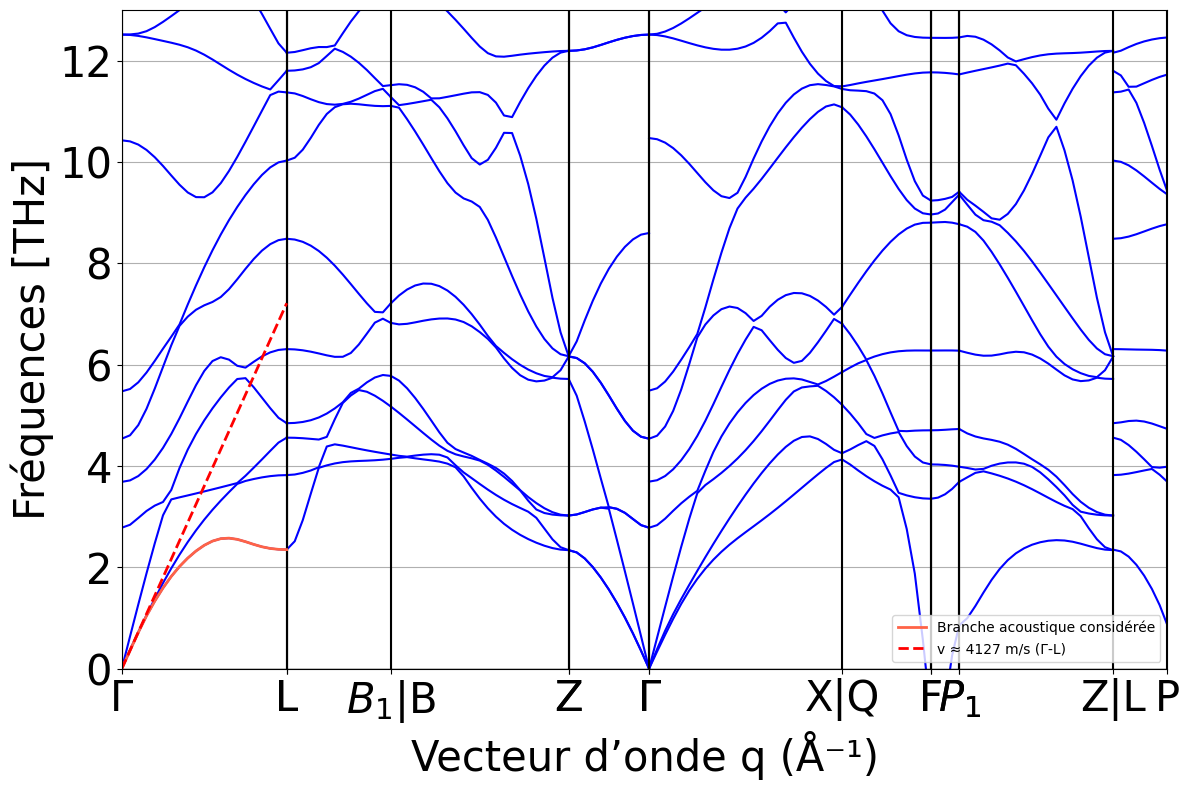

In [10]:
x_fit = np.array([q1[0], q1[1]])
y_fit = np.array([f1[0], f1[1]])
coeffs = np.polyfit(x_fit, y_fit, 1)
q_lin = np.linspace(q1[0], q1[-1], 1000)
f_lin = coeffs[0] * q_lin + coeffs[1]

# Tracé
fig = ph_plot.get_plot()
ax = plt.gca()
ax.plot(q1, f1, color='tomato', label="Branche acoustique considérée", lw=2)
ax.plot(q_lin, f_lin, color='red', ls='--', lw=2, label=f"v ≈ {v1:.0f} m/s (Γ-L)")

plt.xlabel("Vecteur d’onde q (Å⁻¹)")
plt.ylabel("Fréquences [THz]")
plt.ylim(0, 13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()



#### Deuxième bande accoustique K-Γ

In [11]:
v2 = calculer_vitesse(q2, f2, n_points=2,debut=False) # Pour Z–Γ : on prend les derniers points, car c’est eux qui sont proches de Γ.
print(f"Vitesse du son : {v2:.2f} m/s")

Vitesse du son : 4184.63 m/s


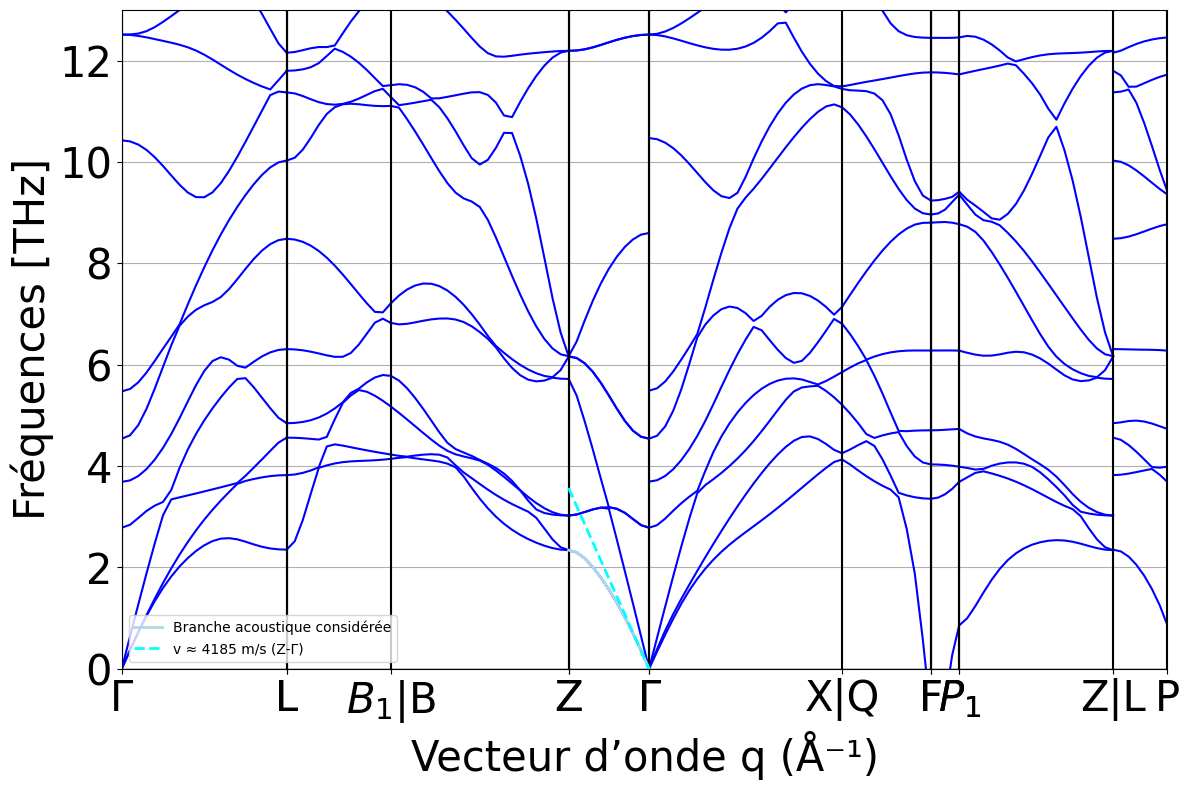

In [12]:
x_fit = np.array([q2[-1], q2[-2]])
y_fit = np.array([f2[-1], f2[-2]])
coeffs = np.polyfit(x_fit, y_fit, 1) 
q_lin = np.linspace(q2[0], q2[-1], 1000)
f_lin = coeffs[0] * q_lin + coeffs[1]

fig = ph_plot.get_plot()
ax = plt.gca()


ax.plot(q2, f2, color='lightblue', label="Branche acoustique considérée", lw=2)
ax.plot(q_lin, f_lin, color='cyan', ls='--', lw=2, label=f"v ≈ {v2:.0f} m/s (Z-Γ)")

# Légendes et axes
plt.xlabel("Vecteur d’onde q (Å⁻¹)")
plt.ylabel("Fréquences [THz]")
plt.ylim(0, 13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


#### Troisième bande accoustique Γ-L

In [13]:
v3 = calculer_vitesse(q3, f3, n_points=2, debut=True)
print(f"Vitesse du son : {v3:.2f} m/s")

Vitesse du son : 7187.23 m/s


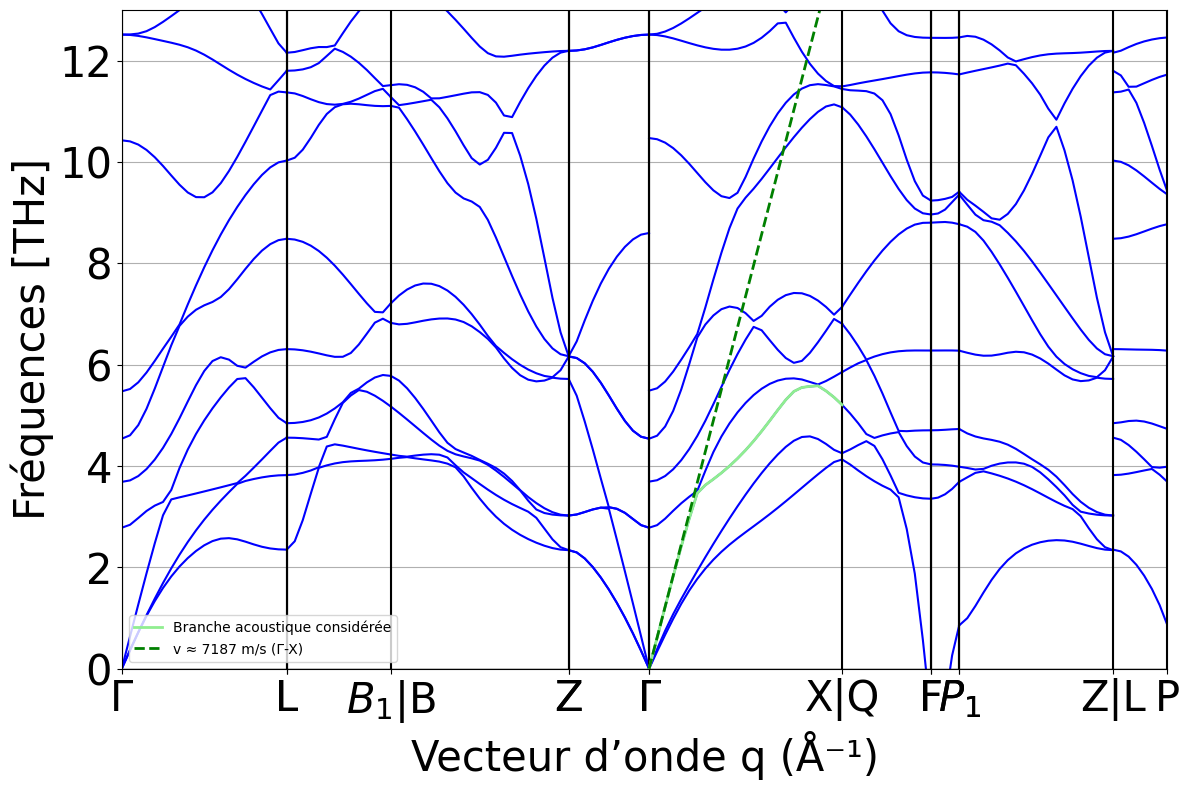

In [14]:
x_fit = np.array([q3[0], q3[1]])
y_fit = np.array([f3[0], f3[1]])
coeffs = np.polyfit(x_fit, y_fit, 1)  # y = a*x + b
q_lin = np.linspace(q3[0], q3[-1], 1000)
f_lin = coeffs[0] * q_lin + coeffs[1]


fig = ph_plot.get_plot()
ax = plt.gca()


ax.plot(q3, f3, color='lightgreen', label="Branche acoustique considérée", lw=2)
ax.plot(q_lin, f_lin, color='green', ls='--', lw=2, label=f"v ≈ {v3:.0f} m/s (Γ-X)")

# Légendes et axes
plt.xlabel("Vecteur d’onde q (Å⁻¹)")
plt.ylabel("Fréquences [THz]")
plt.ylim(0, 13)
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

#### Commentaire : 



L’analyse des différents graphiques montre que la pente de la troisième branche (Γ–X) est la plus élevée. Cela est parfaitement cohérent, car une pente plus importante traduit une vitesse du son plus élevée dans cette direction, ce qui implique que le son se propage plus efficacement dans le matériau selon Γ–X.

On observe également que la pente de la deuxième branche est plus élevée que celle de la première, ce qui se reflète directement dans les vitesses du son associées : plus la pente est faible, plus la vitesse est réduite.

La vitesse du son dépend notamment des interférences constructives et destructives liées aux familles de plans cristallographiques. Chaque direction de l’espace réciproque est perpendiculaire à une famille de plans dans le réseau direct. Ainsi, la vitesse du son est maximale dans la direction où les interférences constructives sont les plus fortes, c’est-à-dire là où la structure du cristal favorise la propagation des ondes élastiques.